### Packages 

In [1]:
# system packages
import sys
import time
import warnings
import os
import fiona
from collections import Counter

# non-geo numeric packages
import numpy as np
import math
from itertools import product, combinations
import pandas as pd

# network and OSM packages
import networkx as nx
import osmnx as ox
city_geo = ox.geocoder.geocode_to_gdf

# Earth engine packages
import ee
import geemap

# General geo-packages
from rasterstats import zonal_stats
import libpysal
import rasterio
import geopandas as gpd
import shapely
from shapely import geometry
from shapely.geometry import Point, MultiLineString, LineString, Polygon, MultiPolygon

/Users/Julian/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/osmnx/projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# loading latest dataframe
popgridmanchester = gpd.read_file('popgridmanchester2.gpkg')

### GEE auth/initialisation, loading health outcome data, extracting population grid data

In [2]:
# Authenticate and Initialize Google Earth Engine
#ee.Authenticate()
ee.Initialize()

In [3]:
# Provided dataset including health outcomes
data = gpd.read_file("Greater_Manchester_NH_GIS.gpkg")

In [4]:
# Health outcome only
data_health = data[['geometry','lsoa11cd','UNID','lsoa11nm','ID','lon','lat','Yrpotlife','Comilldis','Obes_Per_Obesprev_y15', 'Asthma_Per_Asthmaprev_y17', 'heart_Per_heartdiseaseprev_y17', 'Stroke_Per_Strokeprev_y17', 'Cancer_Per_cancerPrev_y17', 'samhi_index2019', 'prop_ibesa', 'est_qof_dep', 'antidep_rate']]


In [ ]:
# specify cities using the excel files with the cities and iso's

# Extract iso-3166 country codes
iso = pd.read_excel('iso_countries.xlsx')

# Extract cities list
cities = pd.read_excel('cities.xlsx') # all cities

# 'cities_adj' serves by default as city-input for functions
# cities_adj = cities
# cities_adj = cities[cities['Included (Y/N)'] == 'Y']
cities_adj = cities[cities['City'].isin(['Manchester'])]
cities_adj = cities_adj.reset_index()

In [ ]:
# function to extract worldpop data from GEE of the cities
def gee_worldpop_extract (city_file, iso, save_path = None):
    
    cities = city_file
    
    # Get included city areas
    OSM_incl = [cities[cities['City'] == city]['OSM_area'].tolist()[0].rsplit(', ') for city in cities['City'].tolist()]

    # Get the city geoms
    obj = [city_geo(city).dissolve()['geometry'].tolist()[0] for city in OSM_incl]

    # Get the city countries
    obj_displ = [city_geo(city).dissolve()['display_name'].tolist()[0].rsplit(', ')[-1]for city in OSM_incl]
    obj_displ = np.where(pd.Series(obj_displ).str.contains("Ivoire"),"CIte dIvoire",obj_displ)

    # Get the country's iso-code
    iso_list = [iso[iso['name'] == ob]['alpha3'].tolist()[0] for ob in obj_displ]

    # Based on the iso-code return the worldpop 2020
    ee_worldpop = [ee.ImageCollection("WorldPop/GP/100m/pop")\
        .filter(ee.Filter.date('2020'))\
        .filter(ee.Filter.inList('country', [io])).first() for io in iso_list]

    # Clip the countries with the city geoms.
    clipped = [ee_worldpop[i].clip(shapely.geometry.mapping(obj[i])) for i in range(0,len(obj))]

    # Create path if non-existent
    if save_path == None:
        path = ''
    else:
        path = save_path
        if not os.path.exists(path):
                    os.makedirs(path)

    # Export as TIFF file.
    # Stored in form path + USA_Los Angeles_2020.tif
    filenames = [path+iso_list[i]+'_'+cities['City'][i]+'_2020.tif' for i in range(len(obj))]
    [geemap.ee_export_image(clipped[i], filename = filenames[i]) for i in range(0,len(obj))]
    return(filenames)
    sys.stdout.flush()

In [ ]:
#### GRID LAT/GRID LON IS NOW BASED ON CENTROID AND NOT CENTROID_M DUE TO
#### OSM NEEDING EPSG 4326 TO EXTRACT STREET NETWORK INFORMATION BASED ON CENTROIDS

# function to create population grids of the cities
def city_grids_format(city_grids, cities_area, grid_size = 100):
    start_time = time.time()
    grids = []
    print(str(grid_size) + 'm resolution grids extraction')
    for i in range(len(city_grids)):
        
        # Open the raster file
        with rasterio.open(city_grids[i]) as src:
            band= src.read() # the population values
            aff = src.transform # the raster bounds and size (affine)
        
        # Get the rowwise arrays, get a 2D dataframe
        grid = pd.DataFrame()
        for b in enumerate(band[0]):
            grid = pd.concat([grid, pd.Series(b[1],name=b[0])],axis=1)
        grid= grid.unstack().reset_index()
        
        # Unstack df to columns
        grid.columns = ['row','col','value']
        grid['minx'] = aff[2]+aff[0]*grid['col']
        grid['miny'] = aff[5]+aff[4]*grid['row']
        grid['maxx'] = aff[2]+aff[0]*grid['col']+aff[0]
        grid['maxy'] = aff[5]+aff[4]*grid['row']+aff[4]
        
        # Create polygon from affine bounds and row/col indices
        grid['geometry'] = [Polygon([(grid.minx[i],grid.miny[i]),
                                   (grid.maxx[i],grid.miny[i]),
                                   (grid.maxx[i],grid.maxy[i]),
                                   (grid.minx[i],grid.maxy[i])])\
                          for i in range(len(grid))]
        
        # Set the df as geo-df
        grid = gpd.GeoDataFrame(grid, crs = 4326) 

        # Get dissolvement_key for dissolvement. 
        grid['row3'] = np.floor(grid['row']/(grid_size/100)).astype(int)
        grid['col3'] = np.floor(grid['col']/(grid_size/100)).astype(int)
        grid['dissolve_key'] = grid['row3'].astype(str) +'-'+ grid['col3'].astype(str)
        
        # Define a city's OSM area as Polygon.
        geo_ls = gpd.GeoSeries(city_geo(cities_area[i].split(', ')).dissolve().geometry)
        
        # Intersect grids with the city boundary Polygon.
        insec = grid.intersection(geo_ls.tolist()[0])
        
        # Exclude grids outside the specified city boundaries
        insec = insec[insec.area > 0]
        
        # Join in other information.
        insec = gpd.GeoDataFrame(geometry = insec, crs = 4326).join(grid.loc[:, grid.columns != 'geometry'])
        
        # Dissolve into block by block grids
        popgrid = insec[['dissolve_key','geometry','row3','col3']].dissolve('dissolve_key')
        
        # Get those grids populations and area. Only blocks with population and full blocks
        popgrid['population'] = round(insec.groupby('dissolve_key')['value'].sum()).astype(int)
        popgrid['area_m'] = round(gpd.GeoSeries(popgrid['geometry'], crs = 4326).to_crs(3043).area).astype(int)
        popgrid = popgrid[popgrid['population'] >= 0]
        popgrid = popgrid[popgrid['area_m'] / popgrid['area_m'].max() > 0.95]

        # Get centroids and coords
        popgrid['centroid'] = popgrid['geometry'].centroid
        popgrid['centroid_m'] = gpd.GeoSeries(popgrid['centroid'], crs = '4326').to_crs(3043)
        popgrid['grid_lon'] = popgrid['centroid_m'].x
        popgrid['grid_lat'] = popgrid['centroid_m'].y
        popgrid = popgrid.reset_index()

        minx = popgrid.bounds['minx']
        maxx = popgrid.bounds['maxx']
        miny = popgrid.bounds['miny']
        maxy = popgrid.bounds['maxy']

        # Some geometries result in a multipolygon when dissolving (like i.e. 0.05 meters), coords error.
        # Therefore recreate the polygon.
        Poly = []
        for k in range(len(popgrid)):
            Poly.append(Polygon([(minx[k],maxy[k]),(maxx[k],maxy[k]),(maxx[k],miny[k]),(minx[k],miny[k])]))
        popgrid['geometry'] = Poly

        grids.append(popgrid)

        print(city_grids[i].rsplit('_')[3], round((time.time() - start_time)/60,2),'mns')
    return(grids)

In [ ]:
%%time
# Required preprocess for information extraction
warnings.filterwarnings('ignore')

# In essence, we use Google Earth Engine to extract a country's grid raster and clip it with the city's preferred OSM area
# Predifine in Excel: the (1) city name as "City" and (2) the OSM area that needs to be extracted as "OSM_area"
# i.e. City = "Los Angeles" and OSM_area = "Los Angeles county, Orange county CA"
files = gee_worldpop_extract(cities_adj, iso, '/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/')

# Files are downloaded automatically to the specified path. Files are also stored in Google with a downloadlink:

In [ ]:
%%time
# Information extraction

# Clip cities from countries, format population grids
population_grids = city_grids_format(files,
                                     cities_adj['OSM_area'],
                                     grid_size = 100) # aggregating upwards to i.e. 200m, 300m etc. is possible
print(' ')

# save the dataframe
popgridmanchester = population_grids[0]

In [ ]:
# adding centroids and lat/lon for CRS 27700
popgridmanchester = popgridmanchester.to_crs("epsg:27700")
popgridmanchester['centroid_27700'] = popgridmanchester['geometry'].centroid
popgridmanchester['grid_lat_27700'] = popgridmanchester['centroid_27700'].y
popgridmanchester['grid_lon_27700'] = popgridmanchester['centroid_27700'].x
popgridmanchester = popgridmanchester.to_crs("epsg:4326")
# renaming earlier grid_lat/lon to denote 4326 CRS
popgridmanchester = popgridmanchester.rename(columns={"grid_lat":"grid_lat_4326", "grid_lon":"grid_lon_4326"})

In [ ]:
# remove centroids to be able to save it as a GPKG
popgridmanchester = popgridmanchester.drop(columns=["centroid_m", 'centroid', 'centroid_27700'])

In [ ]:
# save as gkpg file
popgridmanchester.to_file("popgridmanchester.gpkg", driver="GPKG")

In [2]:
# open gkpg file
popgridmanchester = gpd.read_file("popgridmanchester.gpkg")

### Create data points such as bus stops and restaurants

In [ ]:
# extract Greater Manchester polygon using OSM
manchester_osm = city_geo('Greater Manchester')

In [ ]:
# using OSM to extract data points

# specifying correct ESPG
epsg = "epsg:27700"

# specifying the Greater Manchester polygon
manchester_poly = manchester_osm.geometry.unary_union

# extracting bus stops
bus_stops = ox.geometries_from_polygon(manchester_poly, tags={'highway': 'bus_stop'})
bus_stops = bus_stops.to_crs(epsg)
bus_stops = bus_stops[['geometry']]
bus_stops = bus_stops.reset_index()

# extracting restaurants
restaurants = ox.geometries_from_polygon(manchester_poly, tags={'amenity': ['bar', 'pub', 'restaurant', 'cafe']})
restaurants = restaurants.to_crs(epsg)
restaurants = restaurants[['geometry']]
restaurants = restaurants.reset_index()

# extracting daily shops
shops = ox.geometries_from_polygon(manchester_poly, tags={'shop': ['department_store', 'supermarket', 'convenience']})
shops.to_crs(epsg)
shops = shops[['geometry']]
shops = shops.reset_index()

# extracting cyclelanes
cycleways = ox.geometries_from_polygon(manchester_poly, tags={'cycleway': True, 'highway':'cycleway'})
cycleways.to_crs(epsg)
cycleways_c = cycleways[['geometry']]
cycleways_c = cycleways_c.reset_index()

#Create union out of all geometry extracted
temp_list = []

for index, x in cycleways_c.iterrows():
    temp_list.append(x.geometry)

series = gpd.GeoSeries(temp_list)

# convert to gdf and export as gpkg
cycleways_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(series))
#cycleways_gdf.to_file("cycleways.gpkg", driver="GPKG")

### Population sum of each grid bufferzone

In [3]:
# subset with bufferzone for population density calculation
#buffer_gdf = popgridmanchester.copy()
buffer_gdf = popgridmanchester[152000:152100]
buffer_gdf = buffer_gdf.to_crs("epsg:27700")
buffer_gdf['centroid'] = buffer_gdf['geometry'].centroid
buffer_gdf.geometry = buffer_gdf['centroid'].buffer(500)
buffer_gdf = buffer_gdf['geometry']
buffer_gdf = gpd.GeoDataFrame(buffer_gdf, geometry='geometry')
# CRS back to 4326 to match the TIF population file
buffer_gdf = buffer_gdf.to_crs("epsg:4326")

In [14]:
start_time = time.time()

# load in population files
pop = rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/GBR_Manchester_2020.tif')
ndval = pop.nodatavals
array = pop.read(1)
array[array==ndval] = np.nan
array = array.astype('float64')
affine = pop.transform

# get population sum statistic per bufferzone
statistics = zonal_stats(buffer_gdf, array, affine=affine, stats=['sum'], nodata=ndval)
    
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 0.2548840045928955 seconds


In [15]:
# adding population sum to dataframe
statistics

[{'sum': 7231.709011554718},
 {'sum': 7114.115130901337},
 {'sum': 6866.249577045441},
 {'sum': -93162.77901983261},
 {'sum': -93217.20042848587},
 {'sum': -93242.43440675735},
 {'sum': -93291.00561571121},
 {'sum': -93164.83614349365},
 {'sum': -93035.13281822205},
 {'sum': -92914.95472621918},
 {'sum': -92895.81811094284},
 {'sum': -92912.0314655304},
 {'sum': -92824.98970603943},
 {'sum': -92956.68420982361},
 {'sum': -92840.11265802383},
 {'sum': -92853.28053045273},
 {'sum': 7379.145551681519},
 {'sum': 7474.286425590515},
 {'sum': 7484.876036167145},
 {'sum': 7711.926802158356},
 {'sum': 7758.366380691528},
 {'sum': 7730.856836795807},
 {'sum': 7705.406056880951},
 {'sum': 7789.0158224105835},
 {'sum': 8923.162671089172},
 {'sum': 9761.25179719925},
 {'sum': 9918.203444480896},
 {'sum': 9972.95213508606},
 {'sum': 10095.886235713959},
 {'sum': 9912.648432254791},
 {'sum': 9860.298081874847},
 {'sum': 9576.008004665375},
 {'sum': 9276.561126708984},
 {'sum': 8988.490500450134},
 {

### Population density

### Calculating three-way intersections per grid centroid street network

In [4]:
# column with 0's for the three-way-intersections
popgridmanchester['three-way-intersections'] = 0

In [ ]:
start_time = time.time()

def calculate_intersections(row):
    try:
        G = ox.graph_from_point((row['grid_lat_4326'], row['grid_lon_4326']), dist=500, network_type='drive')
        stats = ox.stats.count_streets_per_node(G)
        return Counter(stats.values())[3]
    except:
        return 0

popgridmanchester['three-way-intersections'] = popgridmanchester.apply(calculate_intersections, axis=1)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")


In [31]:
# save the file to gpkg
popgridmanchester.to_file('popgridmanchester2.gpkg', driver="GPKG")

In [10]:
# test network 
G = ox.graph_from_point((popgridmanchester['grid_lat_4326'][453], 
                             popgridmanchester['grid_lon_4326'][453]), dist=500, network_type='drive')

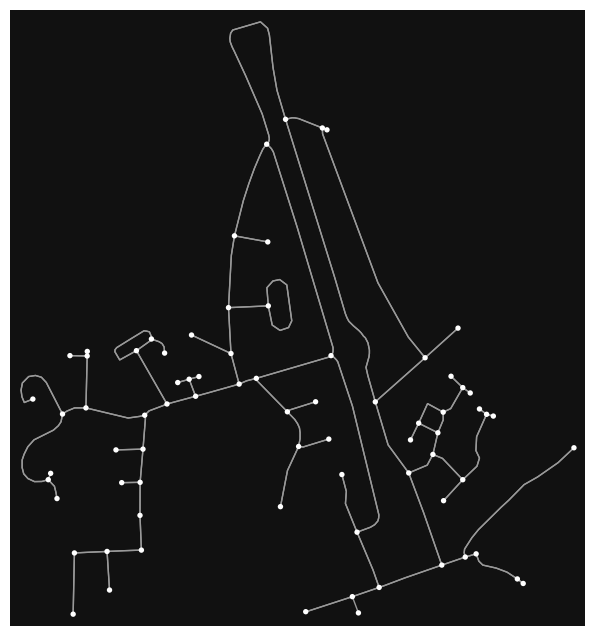

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [11]:
# plot test network graph
ox.plot_graph(G)

In [12]:
# get stats
stats = ox.stats.basic_stats(G, area=popgridmanchester['buffer_area'][453])
stats

{'n': 75,
 'm': 159,
 'k_avg': 4.24,
 'edge_length_total': 13746.23800000001,
 'edge_length_avg': 86.45432704402522,
 'streets_per_node_avg': 2.2666666666666666,
 'streets_per_node_counts': {0: 0, 1: 27, 2: 1, 3: 47},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.36,
  2: 0.013333333333333334,
  3: 0.6266666666666667},
 'intersection_count': 48,
 'street_length_total': 6886.9410000000025,
 'street_segment_count': 80,
 'street_length_avg': 86.08676250000003,
 'circuity_avg': 1.154767689735476,
 'self_loop_proportion': 0.0125,
 'node_density_km': 95.64653660042329,
 'intersection_density_km': 61.2137834242709,
 'edge_density_km': 17530.400746468404,
 'street_density_km': 8782.827392286079}

### Three-way-intersection density

In [49]:
# Getting the area of the bufferzone to get the intersection density
popgridmanchester = popgridmanchester.to_crs("epsg:27700")
popgridmanchester['centroid'] = popgridmanchester['geometry'].centroid
popgridmanchester['buffer'] = popgridmanchester['centroid'].buffer(500)
popgridmanchester['buffer_area'] = popgridmanchester['buffer'].area
popgridmanchester['buffer_area_km'] = popgridmanchester['buffer_area']/1000 # in kilometers
# removing buffer and centroid again to save as gpkg
popgridmanchester = popgridmanchester.drop(columns=['buffer', 'centroid'])

In [50]:
# three-way-intersections divided by the area to get the density (also in square kilometers)
popgridmanchester['three-way-intersection-density'] = popgridmanchester['three-way-intersections']/popgridmanchester['buffer_area']
popgridmanchester['three-way-intersection-density_km'] = popgridmanchester['three-way-intersections']/popgridmanchester['buffer_area_km']


In [54]:
# save the file to gpkg
popgridmanchester.to_file('popgridmanchester2.gpkg', driver="GPKG")

### Street density

In [9]:
start_time = time.time()

def calculate_street_density(row):
    try:
        G = ox.graph_from_point((row['grid_lat_4326'], row['grid_lon_4326']), dist=500, network_type='drive')
        stats = ox.stats.basic_stats(G)
        return stats['street_density_km']
    except:
        return 0

popgridmanchester['street_density_km'] = popgridmanchester.head(100).apply(calculate_street_density, axis=1)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 59.82065200805664 seconds


In [ ]:
# save the file to gpkg
popgridmanchester.to_file('popgridmanchester2.gpkg', driver="GPKG")

### Calculate Euclidean distance from grid centroids to nearest bus stops

In [ ]:
directory = os.getcwd() #Location where files will be saved
c = "/"

In [ ]:
# Calculating distance variabels to POIs

bus_dist_list = []

city = 'Greater Manchester'
espg = 'EPSG:27700'
city_path = directory + c + city

# Load in Manchester grid data
df = popgridmanchester.to_crs(espg)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Load in bus stops
busstop = gpd.read_file('bus_stops.gpkg').to_crs(espg)

# Import points as gdf and loop through them
for index, point in gdf.iterrows():
    polygon_index = busstop.distance(point.geometry).sort_values().index[0]
    nearest_bus = busstop.loc[polygon_index].geometry.centroid

    # Extract coordinates of point
    x, y = point.geometry.centroid.coords.xy
    x = x[0]
    y = y[0]
        
    # Extract coordinates of point
    xx, yy = nearest_bus.xy
    xx = xx[0]
    yy = yy[0]

    # Calculate shortest path
    try:
        ox.distance.euclidean_dist_vec(y, x, yy, xx)
        
    except:
        s_path = 0
        
    else:
        s_path = ox.distance.euclidean_dist_vec(y, x, yy, xx)

    bus_dist_list.append(s_path)

print(city + ' is done')

df['dist_to_busstop'] = bus_dist_list
df

In [ ]:
df.to_file('popgriddistance.gpkg', driver='GPKG')

### Overlay with health outcome data

In [ ]:
# match the crs to the health data crs
popgridmanchester = popgridmanchester.to_crs("epsg:27700")

In [ ]:
# create overlay with the health outcome data
overlay = data_health.overlay(popgridmanchester, how='intersection')

In [ ]:
# save overlay
overlay.to_file("overlay.gpkg", driver="GPKG")